In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install swifter
!pip install scikit-learn
import pandas as pd
import os
import re
import numpy as np
import nltk
import swifter
import gensim.downloader as api
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
DF = pd.read_csv('/content/spam_Emails_data.csv')

# Display dataset info and first few rows
if isinstance(DF, pd.DataFrame):
    print(DF.info())
    print(DF.head())
    print(f"Dataset Loaded: {DF.shape}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
None
  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...
Dataset Loaded: (193852, 2)


In [4]:
#  Optimize Stopwords Lookup using set()
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

#  Fast Text Preprocessing Function
def fast_preprocess(text):
    # Handle NaN values
    if pd.isna(text):
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    tokens = text.split()  # Faster tokenization (split instead of nltk tokenizer)
    tokens = [word for word in tokens if word not in stop_words]  # Fast stopwords removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

# Apply Preprocessing Using Swifter (Fast)
DF["cleaned_text"] = DF["text"].swifter.apply(fast_preprocess)  # Replace "text_column" with actual column name

# Show first 5 rows of preprocessed data
print("\n🔹 **First Few Rows of Preprocessed Data:**")
print(DF.head()) # Changed preprocessed_df to DF to display the original DataFrame with the new column

Pandas Apply:   0%|          | 0/193852 [00:00<?, ?it/s]


🔹 **First Few Rows of Preprocessed Data:**
  label                                               text  \
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...   
1   Ham  got ice thought look az original message ice o...   
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...   
3  Spam  start increasing your odds of success & live s...   
4   Ham  author jra date escapenumber escapenumber esca...   

                                        cleaned_text  
0  viiiiiiagraaaa one want make scream prodigy sc...  
1  got ice thought look az original message ice o...  
2  yo ur wom ne ed escapenumber ch n b e th n f h...  
3  start increasing odds success live sexually he...  
4  author jra date escapenumber escapenumber esca...  


In [5]:
# Load Pre-trained FastText Model (300D)
fasttext_model = api.load("fasttext-wiki-news-subwords-300")  # 300D FastText embeddings
embedding_dim = 300  # Each word has a 300-dimensional vector

#  Convert Email Text into FastText Embeddings
def get_sentence_embedding(text):
    # Handle potential float or NaN values in 'text'
    if isinstance(text, float) or pd.isna(text):
        text = str(text)  # Convert float or NaN to string

    words = text.split()
    word_vectors = [fasttext_model[word] for word in words if word in fasttext_model]

    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)  # Return zero vector if no words are found

    return np.mean(word_vectors, axis=0)  # Compute sentence embedding by averaging word vectors

# Apply FastText embeddings to all emails
X = np.array([get_sentence_embedding(email) for email in tqdm(DF["text"])]) # Changed 'df' to 'DF' and 'email_text' to 'text'
y = DF["label"].values  # Spam or Not Spam labels

# Convert Embeddings to DataFrame with Proper Column Names
column_names = [f"FastText_Dim_{i+1}" for i in range(embedding_dim)]
embedding_DF = pd.DataFrame(X, columns=column_names)
embedding_DF["Label"] = y  # Add Label Column

# Show first few rows
print("\n🔹 **FastText Embeddings DataFrame (First 5 Rows):**")
print(embedding_DF.head())

[==================================================] 100.0% 958.5/958.4MB downloaded


100%|██████████| 193852/193852 [03:04<00:00, 1051.22it/s]



🔹 **FastText Embeddings DataFrame (First 5 Rows):**
   FastText_Dim_1  FastText_Dim_2  FastText_Dim_3  FastText_Dim_4  \
0       -0.005429       -0.001890        0.009536        0.011743   
1        0.013013       -0.004923        0.004098       -0.000592   
2        0.003274       -0.039370        0.037610        0.043302   
3       -0.011668        0.001250        0.010417        0.006774   
4       -0.012034       -0.029282        0.023610        0.025221   

   FastText_Dim_5  FastText_Dim_6  FastText_Dim_7  FastText_Dim_8  \
0       -0.028578       -0.025658       -0.007047       -0.052991   
1       -0.010282       -0.021644       -0.009562       -0.096558   
2       -0.068193       -0.017973        0.035461        0.015867   
3       -0.034936       -0.009688        0.004296       -0.047411   
4       -0.031986       -0.016540        0.011364       -0.053735   

   FastText_Dim_9  FastText_Dim_10  ...  FastText_Dim_292  FastText_Dim_293  \
0       -0.013026        -0.010105  ..

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


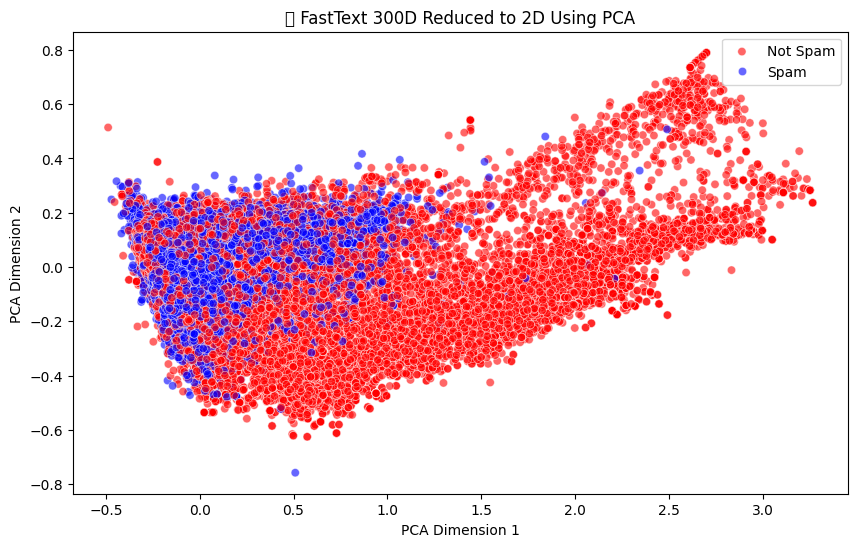

In [9]:
#  **Visualization 1: PCA / t-SNE Plot for FastText (2D Projection)**
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
# Convert y to numerical labels if they are strings
# Assuming 'Spam' corresponds to 1 and 'Ham' corresponds to 0
y_numeric = [1 if label == 'Spam' else 0 for label in y]

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_numeric, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("🔹 FastText 300D Reduced to 2D Using PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(["Not Spam", "Spam"])  # Keep the legend labels as "Not Spam" and "Spam"
plt.show()

In [11]:
# Load Pre-trained GloVe Model (50D)
glove_model = api.load("glove-wiki-gigaword-50")  # 50D GloVe embeddings
embedding_dim_glove = 50  # GloVe is 50D

# Convert Email Text into GloVe Embeddings (No Saving)
def get_glove_embedding(text):
    words = text.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim_glove)
    return np.mean(word_vectors, axis=0)  # Averaging word vectors for sentence embedding

# Apply GloVe embeddings (No Saving)
# Changed 'df' to 'DF' to use the correct DataFrame
# Changed "email_text" to "text" or "cleaned_text" to access correct column
X_glove = np.array([get_glove_embedding(email) for email in tqdm(DF["cleaned_text"])])

# Convert GloVe Embeddings to DataFrame (Without Saving)
# Changed 'df' to 'DF'
glove_df = pd.DataFrame(X_glove, columns=[f"GloVe_Dim_{i+1}" for i in range(embedding_dim_glove)])
glove_df["Label"] = DF["label"]

100%|██████████| 193852/193852 [01:56<00:00, 1665.58it/s]



🔹 **Statistical Comparison Between FastText & GloVe Embeddings**
       FastText_Dim_1  FastText_Dim_2  FastText_Dim_3  FastText_Dim_4  \
count   193852.000000   193852.000000   193852.000000   193852.000000   
mean         0.005692       -0.010581        0.018726        0.009459   
std          0.014631        0.018403        0.020025        0.021732   
min         -0.326640       -0.224820       -0.150980       -0.293860   
25%         -0.000487       -0.019397        0.010064        0.003350   
50%          0.005270       -0.009292        0.015535        0.008503   
75%          0.010799       -0.000084        0.022207        0.013790   
max          0.225260        0.201390        0.271560        0.314340   

       FastText_Dim_5  FastText_Dim_6  FastText_Dim_7  FastText_Dim_8  \
count   193852.000000   193852.000000   193852.000000   193852.000000   
mean        -0.018694       -0.015904        0.003609       -0.073845   
std          0.026879        0.012659        0.019413    

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


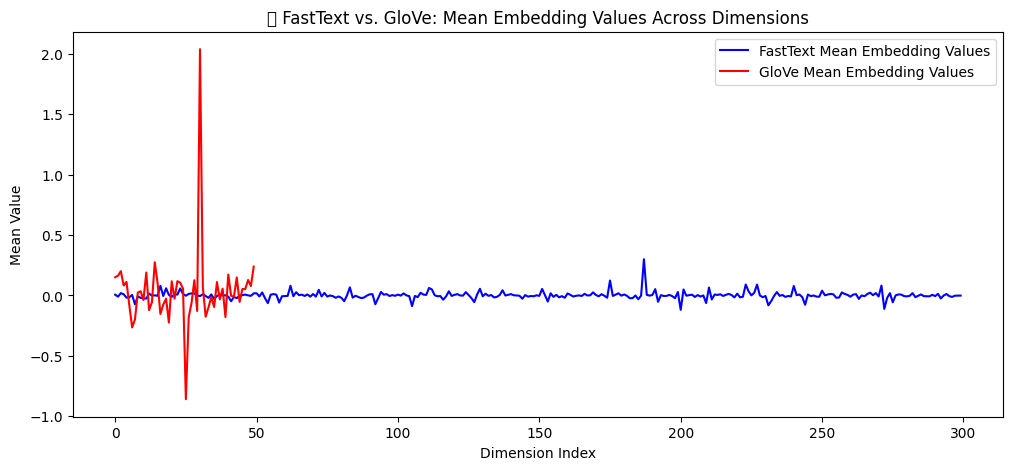


🔹 **Variance in Embeddings (Higher = More Informative)**
📌 FastText Variance: 0.000911
📌 GloVe Variance: 0.044155

✅ GloVe embeddings are more stable but may lose some information compared to FastText.


In [13]:
# Merge FastText & GloVe Embeddings for Comparison (No Saving)
# The variable holding the FastText embeddings is 'embedding_DF', not 'fasttext_df'
comparison_df = pd.concat([embedding_DF, glove_df], axis=1)

# Compare Statistical Properties
print("\n🔹 **Statistical Comparison Between FastText & GloVe Embeddings**")
print(comparison_df.describe())

# Visualize Mean Embedding Differences
# Use 'embedding_DF' instead of 'fasttext_df' to access FastText embeddings
fasttext_means = embedding_DF.iloc[:, :-1].mean(axis=0)
glove_means = glove_df.iloc[:, :-1].mean(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(fasttext_means.values, label="FastText Mean Embedding Values", color='blue')
plt.plot(glove_means.values, label="GloVe Mean Embedding Values", color='red')
plt.title("🔹 FastText vs. GloVe: Mean Embedding Values Across Dimensions")
plt.xlabel("Dimension Index")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

# Which Embedding is More Informative?
# Use 'embedding_DF' instead of 'fasttext_df' to calculate variance for FastText
fasttext_var = embedding_DF.iloc[:, :-1].var().mean()
glove_var = glove_df.iloc[:, :-1].var().mean()

print("\n🔹 **Variance in Embeddings (Higher = More Informative)**")
print(f"📌 FastText Variance: {fasttext_var:.6f}")
print(f"📌 GloVe Variance: {glove_var:.6f}")

# Final Decision Based on Variance
if fasttext_var > glove_var:
    print("\n✅ FastText provides more meaningful information and variation in embeddings.")
else:
    print("\n✅ GloVe embeddings are more stable but may lose some information compared to FastText.")